In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# Read the data from Sheet1 (which contains the metal concentration data)
df = pd.read_excel("HPI_Datasheet.xlsx", sheet_name="Sheet1")
print("Data loaded successfully!")
print(f"Data shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

Data loaded successfully!
Data shape: (42, 13)

First 5 rows:
   Sample ID         Pb       Cd        Cr       Hg      Co       Ni  \
0          1     1.2500   2.0475  18.86625  0.37500  4.1675  21.9550   
1          2     1.2500  13.3380  37.70625  0.37500  1.2500   1.2500   
2          3     1.2500   1.8720  68.57625  0.37500  5.5950  20.0025   
3          4     1.2500   6.4350  14.78875  0.37500  1.2500   5.6875   
4          5  2689.8975   7.8000  24.04875  1.01275  3.0250  52.7925   

           Al          Fe        Cu        Zn         Mn       As  
0  2849.26625   9219.2975  342.6425  408.7250  2189.7475  17.6150  
1  2244.35750   8062.3800  339.0900  250.0525  1097.1975   1.2500  
2  5647.76750  11449.1825  466.3300  558.1450  1569.5975  91.1475  
3  4057.42875  11744.1975  222.1325  446.5475  1237.5225   1.2500  
4  2235.84000   2770.1975  150.3725  883.5125   407.4475   1.2500  


In [15]:
# Read the standards from Sheet2
standards_sheet = pd.read_excel("HPI_Datasheet.xlsx", sheet_name="Sheet2")
print("\nStandards data:")
print(standards_sheet.head())


Standards data:
  Metal    Si    Ii  Reference
0    Mn   400   100        NaN
1    Fe   300   200        NaN
2    Co   100    50        NaN
3    Cu  2000  1000        NaN
4    Zn  3000  1000        NaN


In [16]:
# Create standards DataFrame from the Excel data
standards_df = standards_sheet.set_index('Metal')[['Si', 'Ii']]
print("\nStandards DataFrame:")
print(standards_df)


Standards DataFrame:
         Si    Ii
Metal            
Mn      400   100
Fe      300   200
Co      100    50
Cu     2000  1000
Zn     3000  1000
As       50    10
Hg        6     2
Ni       70    20
Cd        5     3
Pb       50    10
Cr      100    50
Al      200    50


In [17]:
print("\nData columns:", df.columns.tolist())
print("\nStandards metals:", standards_df.index.tolist())

# Check which metals are available in both datasets
available_metals = [metal for metal in standards_df.index if metal in df.columns]
print(f"\nAvailable metals for HPI calculation: {available_metals}")



Data columns: ['Sample ID', 'Pb', 'Cd', 'Cr', 'Hg', 'Co', 'Ni', 'Al', 'Fe', 'Cu', 'Zn', 'Mn', 'As']

Standards metals: ['Mn', 'Fe', 'Co', 'Cu', 'Zn', 'As', 'Hg', 'Ni', 'Cd', 'Pb', 'Cr', 'Al']

Available metals for HPI calculation: ['Mn', 'Fe', 'Co', 'Cu', 'Zn', 'As', 'Hg', 'Ni', 'Cd', 'Pb', 'Cr', 'Al']


In [18]:
# Fill any missing values with 0
df = df.fillna(0)
print("Missing values filled with 0")

Missing values filled with 0


In [19]:
# Use the reciprocal of the standard limit
standards_df["Wi"] = 1.0 / standards_df["Si"]
print("\nUnit weights (Wi) calculated:")
print(standards_df)


Unit weights (Wi) calculated:
         Si    Ii        Wi
Metal                      
Mn      400   100  0.002500
Fe      300   200  0.003333
Co      100    50  0.010000
Cu     2000  1000  0.000500
Zn     3000  1000  0.000333
As       50    10  0.020000
Hg        6     2  0.166667
Ni       70    20  0.014286
Cd        5     3  0.200000
Pb       50    10  0.020000
Cr      100    50  0.010000
Al      200    50  0.005000


In [20]:
# For each metal column M, compute: Qi = (Ci - Ii) / (Si - Ii) * 100
for metal in available_metals:
    Si, Ii = standards_df.loc[metal, ["Si", "Ii"]]
    df[f"Q_{metal}"] = (df[metal] - Ii) / (Si - Ii) * 100
    print(f"Sub-index Q_{metal} calculated")

print(f"\nSub-indices calculated for {len(available_metals)} metals")


Sub-index Q_Mn calculated
Sub-index Q_Fe calculated
Sub-index Q_Co calculated
Sub-index Q_Cu calculated
Sub-index Q_Zn calculated
Sub-index Q_As calculated
Sub-index Q_Hg calculated
Sub-index Q_Ni calculated
Sub-index Q_Cd calculated
Sub-index Q_Pb calculated
Sub-index Q_Cr calculated
Sub-index Q_Al calculated

Sub-indices calculated for 12 metals


In [21]:
# Multiply each Q_<metal> by its Wi
for metal in available_metals:
    Wi = standards_df.loc[metal, "Wi"]
    df[f"WQ_{metal}"] = df[f"Q_{metal}"] * Wi
    print(f"Weighted sub-index WQ_{metal} calculated")

print(f"\nWeighted sub-indices calculated for {len(available_metals)} metals")


Weighted sub-index WQ_Mn calculated
Weighted sub-index WQ_Fe calculated
Weighted sub-index WQ_Co calculated
Weighted sub-index WQ_Cu calculated
Weighted sub-index WQ_Zn calculated
Weighted sub-index WQ_As calculated
Weighted sub-index WQ_Hg calculated
Weighted sub-index WQ_Ni calculated
Weighted sub-index WQ_Cd calculated
Weighted sub-index WQ_Pb calculated
Weighted sub-index WQ_Cr calculated
Weighted sub-index WQ_Al calculated

Weighted sub-indices calculated for 12 metals


In [22]:
# Sum the weighted sub-indices and divide by total weight
available_standards = standards_df.loc[available_metals]
total_W = available_standards["Wi"].sum()
df["HPI"] = df[[f"WQ_{m}" for m in available_metals]].sum(axis=1) / total_W

print(f"\nTotal weight (sum of Wi): {total_W:.6f}")
print("HPI calculated successfully!")


Total weight (sum of Wi): 0.452619
HPI calculated successfully!


In [23]:
df["Classification"] = np.where(df["HPI"] <= 100, 
                               "Suitable for consumption", 
                               "Unsuitable for consumption")

print("Sample classification completed!")

Sample classification completed!


In [24]:
# Display the first few rows
print("\n=== HPI Results (first 10 rows) ===")
result_columns = ["Sample ID", "HPI", "Classification"]
print(df[result_columns].head(10))

# Get summary statistics
print("\n=== HPI Summary Statistics ===")
print(df["HPI"].describe())

# Count classifications
print("\n=== Classification Summary ===")
print(df["Classification"].value_counts())


=== HPI Results (first 10 rows) ===
   Sample ID          HPI              Classification
0          1    51.385144    Suitable for consumption
1          2   283.429276  Unsuitable for consumption
2          3    93.676250    Suitable for consumption
3          4   170.904396  Unsuitable for consumption
4          5   426.379490  Unsuitable for consumption
5          6    36.420698    Suitable for consumption
6          7  1760.572362  Unsuitable for consumption
7          8   301.921970  Unsuitable for consumption
8          9   398.905908  Unsuitable for consumption
9         10    -9.499037    Suitable for consumption

=== HPI Summary Statistics ===
count      42.000000
mean      227.035943
std       308.924292
min       -13.680575
25%        51.960385
50%       138.370347
75%       287.597303
max      1760.572362
Name: HPI, dtype: float64

=== Classification Summary ===
Classification
Unsuitable for consumption    25
Suitable for consumption      17
Name: count, dtype: int64


In [25]:
# Export the final table with HPI and Classification to Excel
output_filename = "Tamarind_HPI_Results.xlsx"
df.to_excel(output_filename, index=False)
print(f"\nResults saved to {output_filename}")


Results saved to Tamarind_HPI_Results.xlsx


<Figure size 1200x600 with 0 Axes>

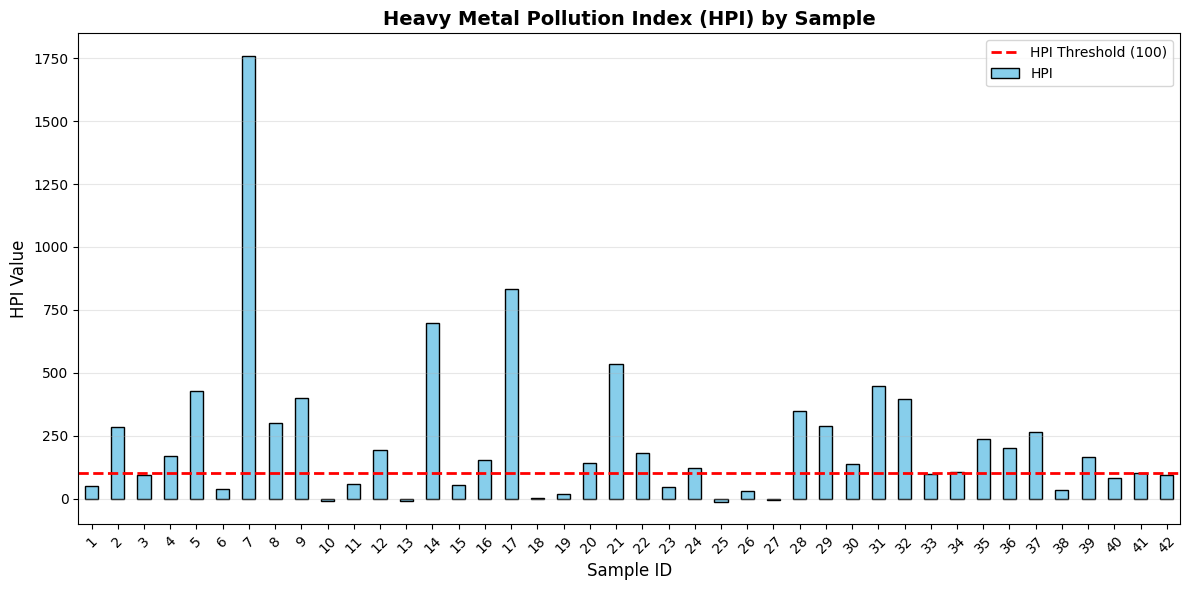

In [26]:
# Plot a bar chart of HPI by sample
plt.figure(figsize=(12, 6))
df.plot.bar(x="Sample ID", y="HPI", figsize=(12, 6), color='skyblue', edgecolor='black')
plt.axhline(100, color="red", linestyle="--", linewidth=2, label="HPI Threshold (100)")
plt.title("Heavy Metal Pollution Index (HPI) by Sample", fontsize=14, fontweight='bold')
plt.xlabel("Sample ID", fontsize=12)
plt.ylabel("HPI Value", fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

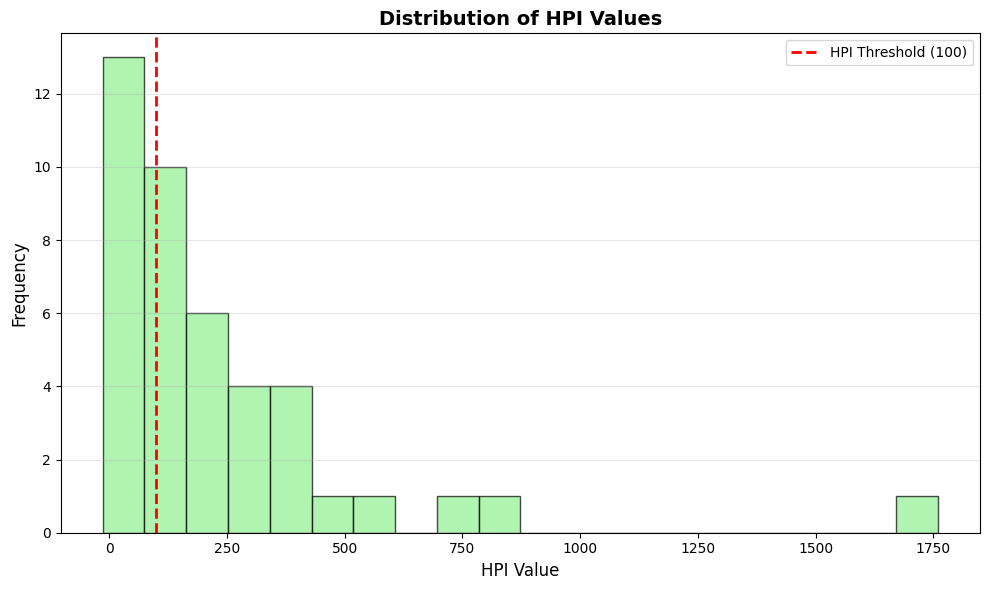


HPI Analysis completed successfully!
Metals included in analysis: Mn, Fe, Co, Cu, Zn, As, Hg, Ni, Cd, Pb, Cr, Al
Total samples analyzed: 42
Average HPI: 227.04
Samples suitable for consumption: 17
Samples unsuitable for consumption: 25


In [27]:
# Additional visualization: HPI distribution
plt.figure(figsize=(10, 6))
plt.hist(df["HPI"], bins=20, edgecolor='black', alpha=0.7, color='lightgreen')
plt.axvline(100, color="red", linestyle="--", linewidth=2, label="HPI Threshold (100)")
plt.title("Distribution of HPI Values", fontsize=14, fontweight='bold')
plt.xlabel("HPI Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nHPI Analysis completed successfully!")
print(f"Metals included in analysis: {', '.join(available_metals)}")
print(f"Total samples analyzed: {len(df)}")
print(f"Average HPI: {df['HPI'].mean():.2f}")
print(f"Samples suitable for consumption: {sum(df['Classification'] == 'Suitable for consumption')}")
print(f"Samples unsuitable for consumption: {sum(df['Classification'] == 'Unsuitable for consumption')}")
